# **Daniel Minaya Vargas**

# Transfer Learning

En este notebook resolveremos un problema real usando redes pre-entrenadas y transfer learning.

## Patrones geométricos de Kunisch
En el año 1998, Norbert Kunisch (un reconocido arqueólogo clásico alemán) publicó su libro "Ornamente Geometrischer Vasen", en donde clasificó diferentes patrones geométricos de vasijas griegas que se encuentran en diferentes museos de Europa. Su trabajo fue muy importante para determinar tiempos y ubicaciones de muchos objetos esparcidos por todo el continente.

Su libro es un compendio de los diferentes patrones geométricos presentes en vasijas y las anotaciones textuales de los patrones en diferentes idiomas.

<img src="http://www.ivan-sipiran.com/downloads/0.jpg" alt="Test" height="200" />

<img src="http://www.ivan-sipiran.com/downloads/6.jpg" alt="Test" height="200" />

<img src="http://www.ivan-sipiran.com/downloads/36.jpg" alt="Test" height="200" />

<img src="http://www.ivan-sipiran.com/downloads/92.jpg" alt="Test" height="200" />

<img src="http://www.ivan-sipiran.com/downloads/210.jpg" alt="Test" height="200" />

# El problema

En el museo de arqueología Schloss Eggenberg quieren realizar un análisis automático de patrones en vasijas usando el compendio de Kunisch. Para esto nosotros realizamos primero un trabajo de escaneo del libro entero y de OCR para extraer tanto los patrones como las anotaciones textuales.

Como resultado tenemos 348 patrones, clasificados en seis clases:

*   Ornamentos circulares
*   Ornamentos triangulares
*   Ornamenros rectangulares
*   Pictografías
*   Trazos y líneas
*   Romboidales

Nuestro primer objetivo es encontrar una forma de lograr una alta eficacia de clasificación de estos patrones. Sin embargo, al tener muy poca data, trataremos de resolverlo con la técnica dle transfer learning.



In [1]:
#Descargamos la data
!wget http://www.ivan-sipiran.com/downloads/data_patterns2.zip
!unzip data_patterns2.zip

--2023-10-26 01:58:19--  http://www.ivan-sipiran.com/downloads/data_patterns2.zip
Resolving www.ivan-sipiran.com (www.ivan-sipiran.com)... 66.96.149.31
Connecting to www.ivan-sipiran.com (www.ivan-sipiran.com)|66.96.149.31|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28575047 (27M) [application/zip]
Saving to: ‘data_patterns2.zip’

data_patterns2.zip  100%[===================>]  27.25M  13.7MB/s    in 2.0s    

2023-10-26 01:58:21 (13.7 MB/s) - ‘data_patterns2.zip’ saved [28575047/28575047]

Archive:  data_patterns2.zip
   creating: data/
  inflating: data/class_labels.csv   
  inflating: data/0.jpg              
  inflating: data/6.jpg              
  inflating: data/36.jpg             
  inflating: data/92.jpg             
  inflating: data/210.jpg            
   creating: data/patrones/
   creating: data/patrones/69c/
  inflating: data/patrones/69c/69c_pattern.png  
   creating: data/patrones/2a/
  inflating: data/patrones/2a/2a_pattern.png  
   creating:

# La Solución

Primero creamos nuestras tres colecciones de datos: train, val y test. Los datos de train serán usados para entrenar el modelo, los datos de validación serán usados para probar el modelo durante entrenamiento, y los datos de test serán usados para evaluar el performance final del modelo.

Hacemos un poco de data engineering para crear nuestras colecciones.

*   Datos de train: 70%
*   Datos de val: 10%
*   Datos de test: 20%

La partición se hace dentro de cada clase para asegurar representatividad en cada clase.



In [2]:
import pandas as pd
import math
import random
import os
import shutil

random.seed(30)

#Leemos la metadata del dataset desde el archivo CSV
df = pd.read_csv('data/class_labels.csv', header=None)
classes = df[1].unique()
classesFinal = [cl.replace(' ', '_') for cl in classes]
print(classesFinal)

#Creamos folders para almacenar la data. NOTA: trata de ejecutar esta celda solo una vez, ya que
# crea los folders y ese paso solo se ejecuta una vez
try:
    os.mkdir('dataset')
except OSError:
    print ("No se pudo crear folder dataset")
else:
    print ("Se creó folder dataset")

try:
    os.mkdir('dataset/train')
except OSError:
    print ("No se pudo crear folder dataset")
else:
    print ("Se creó folder dataset")

try:
    os.mkdir('dataset/test')
except OSError:
    print ("No se pudo crear folder dataset")
else:
    print ("Se creó folder dataset")

try:
    os.mkdir('dataset/val')
except OSError:
    print ("No se pudo crear folder dataset")
else:
    print ("Se creó folder dataset")

for cl in classesFinal:
    try:
        os.mkdir(os.path.join('dataset', "train", cl))
    except OSError:
        print (f"No se pudo crear folder train {cl}")
    else:
        print (f"Se creó folder train {cl}")

    try:
        os.mkdir(os.path.join('dataset', "test", cl))
    except OSError:
        print (f"No se pudo crear folder test {cl}")
    else:
        print (f"Se creó folder test {cl}")

    try:
        os.mkdir(os.path.join('dataset', "val", cl))
    except OSError:
        print (f"No se pudo crear folder val {cl}")
    else:
        print (f"Se creó folder val {cl}")

['circular_ornaments', 'triangular_ornaments', 'rectangular_ornaments', 'pictographics', 'lozenge', 'strokes_and_lines']
Se creó folder dataset
Se creó folder dataset
Se creó folder dataset
Se creó folder dataset
Se creó folder train circular_ornaments
Se creó folder test circular_ornaments
Se creó folder val circular_ornaments
Se creó folder train triangular_ornaments
Se creó folder test triangular_ornaments
Se creó folder val triangular_ornaments
Se creó folder train rectangular_ornaments
Se creó folder test rectangular_ornaments
Se creó folder val rectangular_ornaments
Se creó folder train pictographics
Se creó folder test pictographics
Se creó folder val pictographics
Se creó folder train lozenge
Se creó folder test lozenge
Se creó folder val lozenge
Se creó folder train strokes_and_lines
Se creó folder test strokes_and_lines
Se creó folder val strokes_and_lines


In [3]:
#Hacemos el pre-procesamiento de los datos, cada imagen va a parar a su respectivo folder
dataset = dict()

for index, cl in enumerate(classes):
    grouped_data = df.groupby(1).get_group(cl)[0].tolist()
    dataset[classesFinal[index]] = grouped_data

for k,v in dataset.items():
    print(f'Class: {k}, Length: {len(v)}')

for k,v in dataset.items():
    valNumber = math.ceil(0.1 * len(v))
    testNumber = math.ceil(0.2 * len(v))
    trainNumber = len(v) - valNumber - testNumber

    random.shuffle(v)
    elemTrain = v[:trainNumber]
    elemVal = v[trainNumber:trainNumber+valNumber]
    elemTest = v[trainNumber+valNumber:]

    assert (valNumber + testNumber + trainNumber) == len(v)

    pathTrain = './dataset/train/'
    pathSource = './data/patrones/'

    #Copiar archivos de train
    for elem in elemTrain:
        shutil.copy(os.path.join(pathSource,elem,elem+'_pattern.png'), os.path.join(pathTrain, k))

    pathTest = './dataset/test/'
    pathSource = './data/patrones/'

    #Copiar archivos de test
    for elem in elemTest:
        shutil.copy(os.path.join(pathSource,elem,elem+'_pattern.png'), os.path.join(pathTest, k))

    pathVal = './dataset/val/'
    pathSource = './data/patrones/'

    #Copiar archivos de train
    for elem in elemVal:
        shutil.copy(os.path.join(pathSource,elem,elem+'_pattern.png'), os.path.join(pathVal, k))

Class: circular_ornaments, Length: 72
Class: triangular_ornaments, Length: 81
Class: rectangular_ornaments, Length: 87
Class: pictographics, Length: 26
Class: lozenge, Length: 46
Class: strokes_and_lines, Length: 36


# Creación de Datasets

Se crean los datasets y dataloaders de Pytorch, que usarás para tu tarea.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import time
import os
import copy

pathDataset = 'dataset/'

train_dataset = torchvision.datasets.ImageFolder(pathDataset + 'train',
                                                    transform = transforms.Compose([
                                                        transforms.RandomVerticalFlip(),
                                                        transforms.RandomHorizontalFlip(),
                                                        transforms.RandomResizedCrop(224),
                                                                    transforms.ToTensor(),
                                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                        std = [0.229, 0.224, 0.225])]))

val_dataset = torchvision.datasets.ImageFolder(pathDataset + 'val',
                                                    transform = transforms.Compose([ transforms.Resize(256),
                                                                    transforms.CenterCrop(224),
                                                                    transforms.ToTensor(),
                                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                        std = [0.229, 0.224, 0.225])]))

test_dataset = torchvision.datasets.ImageFolder(pathDataset + 'test',
                                                    transform = transforms.Compose([ transforms.Resize(224),
                                                                    transforms.ToTensor(),
                                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                        std = [0.229, 0.224, 0.225])]))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

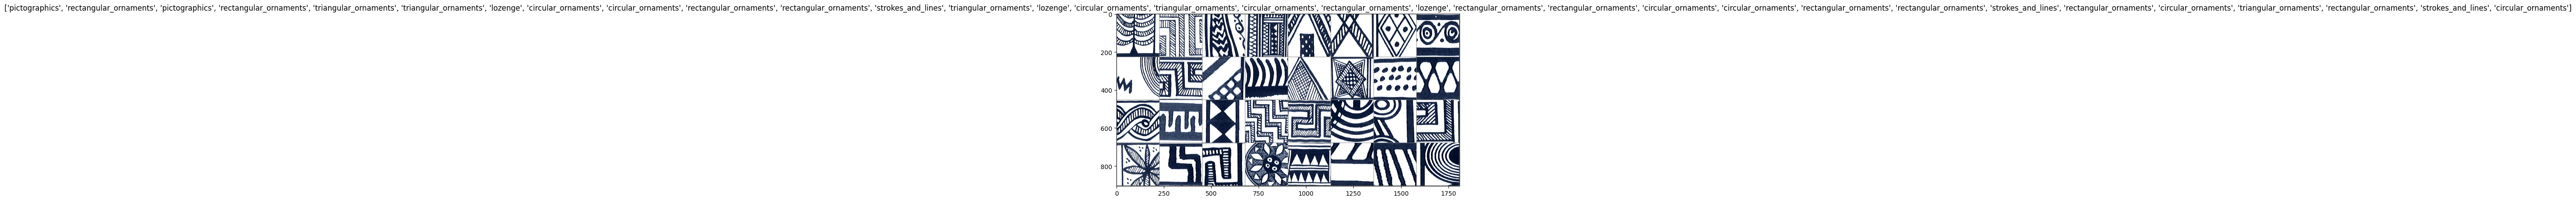

In [5]:
class_names = train_dataset.classes

def imshow(inp, title = None):
    plt.figure(figsize=(10,20))
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5])
    std = np.array([0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

device = ('cuda' if torch.cuda.is_available() else 'cpu')

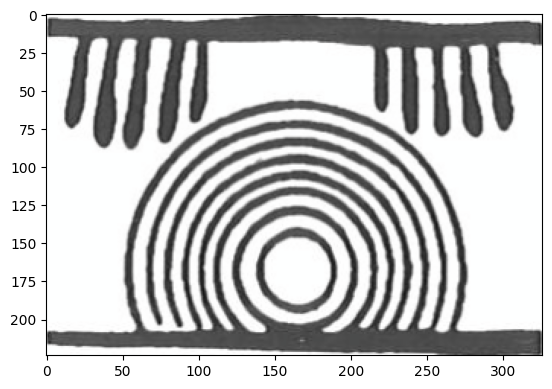

In [6]:
img = test_dataset[3][0]
inp = img.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean
inp = np.clip(inp, 0, 1)

plt.figure()
plt.imshow(inp.squeeze())
plt.show()

In [7]:
def train_model(model, criterio, optimizer, scheduler, num_epochs = 25):
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        #Train model
        scheduler.step()
        model.train()

        running_loss = 0.0
        running_corrects = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss /len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)

        print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        #Validation
        model.eval()
        running_loss = 0.0
        running_corrects = 0.0

        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss /len(val_dataset)
        epoch_acc = running_corrects.double() / len(val_dataset)

        print('Val Loss: {:.4f} Acc: {:.4f}\n'.format(epoch_loss, epoch_acc))
        val_loss.append(epoch_loss)
        val_acc.append(epoch_acc)

        # No guardamos modelo overfiteado agregando la segunda condición
        if epoch_acc > best_acc and train_acc[epoch] - val_acc[epoch] < 0.05:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since

    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed % 60))
    print('Best val accuracy: {:.4f}\n'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, train_loss, train_acc, val_loss, val_acc

# Solución 1: Fine-tuning

Utiliza fine-tuning para el problema anterior y reporta el accuracy de test. Intenta obtener el accuracy de test más alto posible, sin que el modelo haga overfitting. Considera overfitting cuando la diferencia entre accuracy de train y accuracy de validación tengan una diferencia de más de 5%.

## ResNet

In [8]:
num_model = [18, 34, 50, 101, 152]
models_resnet, train_loss_resnet, train_acc_resnet, val_loss_resnet, val_acc_resnet= [], [], [], [], []
num_epochs = 10

for num in num_model:
    name = f"models.resnet{num}"

    model_ft = eval(name)(pretrained=True)

    num_ft = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ft, 6)

    model_ft = model_ft.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    print(f"Modelo ResNet{num}")
    model_ft, train_loss, train_acc, val_loss, val_acc = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

    models_resnet.append(model_ft)
    train_loss_resnet.append(train_loss)
    train_acc_resnet.append(train_acc)
    val_loss_resnet.append(val_loss)
    val_acc_resnet.append(val_acc)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 79.2MB/s]


Modelo ResNet18
Epoch 1/10
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Train Loss: 1.8208 Acc: 0.1949
Val Loss: 1.7966 Acc: 0.2368

Epoch 2/10
----------
Train Loss: 1.6417 Acc: 0.3771
Val Loss: 1.5289 Acc: 0.5000

Epoch 3/10
----------
Train Loss: 1.2750 Acc: 0.5254
Val Loss: 1.4006 Acc: 0.5000

Epoch 4/10
----------
Train Loss: 1.1403 Acc: 0.5932
Val Loss: 1.2786 Acc: 0.5526

Epoch 5/10
----------
Train Loss: 0.9520 Acc: 0.6695
Val Loss: 1.1615 Acc: 0.6053

Epoch 6/10
----------
Train Loss: 0.8996 Acc: 0.6780
Val Loss: 1.1656 Acc: 0.6053

Epoch 7/10
----------
Train Loss: 0.7558 Acc: 0.7542
Val Loss: 1.1917 Acc: 0.5789

Epoch 8/10
----------
Train Loss: 0.7922 Acc: 0.7331
Val Loss: 1.1802 Acc: 0.5789

Epoch 9/10
----------
Train Loss: 0.7877 Acc: 0.7331
Val Loss: 1.1629 Acc: 0.5789

Epoch 10/10
----------
Train Loss: 0.7711 Acc: 0.7500
Val Loss: 1.1854 Acc: 0.5789

Training complete in 0m 27s
Best val accuracy: 0.5526



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 161MB/s]


Modelo ResNet34
Epoch 1/10
----------
Train Loss: 1.9031 Acc: 0.2203
Val Loss: 1.7853 Acc: 0.3421

Epoch 2/10
----------
Train Loss: 1.5323 Acc: 0.3941
Val Loss: 1.5074 Acc: 0.4474

Epoch 3/10
----------
Train Loss: 1.2406 Acc: 0.5720
Val Loss: 1.4102 Acc: 0.4474

Epoch 4/10
----------
Train Loss: 1.0196 Acc: 0.6525
Val Loss: 1.2679 Acc: 0.4211

Epoch 5/10
----------
Train Loss: 0.8731 Acc: 0.7203
Val Loss: 1.2075 Acc: 0.5526

Epoch 6/10
----------
Train Loss: 0.7395 Acc: 0.7712
Val Loss: 1.1302 Acc: 0.5789

Epoch 7/10
----------
Train Loss: 0.7433 Acc: 0.7669
Val Loss: 1.1333 Acc: 0.5789

Epoch 8/10
----------
Train Loss: 0.6964 Acc: 0.7754
Val Loss: 1.1274 Acc: 0.6053

Epoch 9/10
----------
Train Loss: 0.6615 Acc: 0.8008
Val Loss: 1.1544 Acc: 0.5526

Epoch 10/10
----------
Train Loss: 0.6347 Acc: 0.8263
Val Loss: 1.1447 Acc: 0.5263

Training complete in 0m 24s
Best val accuracy: 0.4474



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 132MB/s]


Modelo ResNet50
Epoch 1/10
----------
Train Loss: 1.7409 Acc: 0.2924
Val Loss: 1.6825 Acc: 0.2632

Epoch 2/10
----------
Train Loss: 1.5446 Acc: 0.4619
Val Loss: 1.5450 Acc: 0.3421

Epoch 3/10
----------
Train Loss: 1.3365 Acc: 0.5466
Val Loss: 1.4093 Acc: 0.4474

Epoch 4/10
----------
Train Loss: 1.1825 Acc: 0.5805
Val Loss: 1.2763 Acc: 0.5526

Epoch 5/10
----------
Train Loss: 1.0177 Acc: 0.6737
Val Loss: 1.2741 Acc: 0.5263

Epoch 6/10
----------
Train Loss: 0.9041 Acc: 0.6907
Val Loss: 1.1195 Acc: 0.5789

Epoch 7/10
----------
Train Loss: 0.8148 Acc: 0.7034
Val Loss: 1.1246 Acc: 0.6053

Epoch 8/10
----------
Train Loss: 0.8323 Acc: 0.7034
Val Loss: 1.1329 Acc: 0.5789

Epoch 9/10
----------
Train Loss: 0.8080 Acc: 0.7585
Val Loss: 1.1354 Acc: 0.5789

Epoch 10/10
----------
Train Loss: 0.7825 Acc: 0.7712
Val Loss: 1.1345 Acc: 0.6053

Training complete in 0m 35s
Best val accuracy: 0.5526



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 137MB/s]


Modelo ResNet101
Epoch 1/10
----------
Train Loss: 1.7905 Acc: 0.1780
Val Loss: 1.6576 Acc: 0.2632

Epoch 2/10
----------
Train Loss: 1.5199 Acc: 0.4492
Val Loss: 1.4804 Acc: 0.4211

Epoch 3/10
----------
Train Loss: 1.3268 Acc: 0.5381
Val Loss: 1.4059 Acc: 0.5263

Epoch 4/10
----------
Train Loss: 1.1016 Acc: 0.6356
Val Loss: 1.3039 Acc: 0.5526

Epoch 5/10
----------
Train Loss: 0.9744 Acc: 0.6780
Val Loss: 1.2001 Acc: 0.5789

Epoch 6/10
----------
Train Loss: 0.8534 Acc: 0.7458
Val Loss: 1.1883 Acc: 0.5789

Epoch 7/10
----------
Train Loss: 0.8077 Acc: 0.7500
Val Loss: 1.1438 Acc: 0.5789

Epoch 8/10
----------
Train Loss: 0.7597 Acc: 0.7966
Val Loss: 1.1353 Acc: 0.5789

Epoch 9/10
----------
Train Loss: 0.7489 Acc: 0.7754
Val Loss: 1.1105 Acc: 0.5789

Epoch 10/10
----------
Train Loss: 0.7182 Acc: 0.7797
Val Loss: 1.1086 Acc: 0.6316

Training complete in 0m 51s
Best val accuracy: 0.5263



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 146MB/s]


Modelo ResNet152
Epoch 1/10
----------
Train Loss: 1.7611 Acc: 0.2288
Val Loss: 1.6401 Acc: 0.4474

Epoch 2/10
----------
Train Loss: 1.5163 Acc: 0.5169
Val Loss: 1.5046 Acc: 0.5000

Epoch 3/10
----------
Train Loss: 1.2943 Acc: 0.5975
Val Loss: 1.3540 Acc: 0.5526

Epoch 4/10
----------
Train Loss: 1.0590 Acc: 0.7076
Val Loss: 1.2183 Acc: 0.6316

Epoch 5/10
----------
Train Loss: 0.9552 Acc: 0.6907
Val Loss: 1.1976 Acc: 0.5789

Epoch 6/10
----------
Train Loss: 0.8424 Acc: 0.7203
Val Loss: 1.1262 Acc: 0.6053

Epoch 7/10
----------
Train Loss: 0.8007 Acc: 0.7415
Val Loss: 1.1229 Acc: 0.6316

Epoch 8/10
----------
Train Loss: 0.7380 Acc: 0.7669
Val Loss: 1.1185 Acc: 0.6053

Epoch 9/10
----------
Train Loss: 0.7859 Acc: 0.7458
Val Loss: 1.1051 Acc: 0.6316

Epoch 10/10
----------
Train Loss: 0.7350 Acc: 0.7669
Val Loss: 1.1267 Acc: 0.6316

Training complete in 1m 7s
Best val accuracy: 0.5526



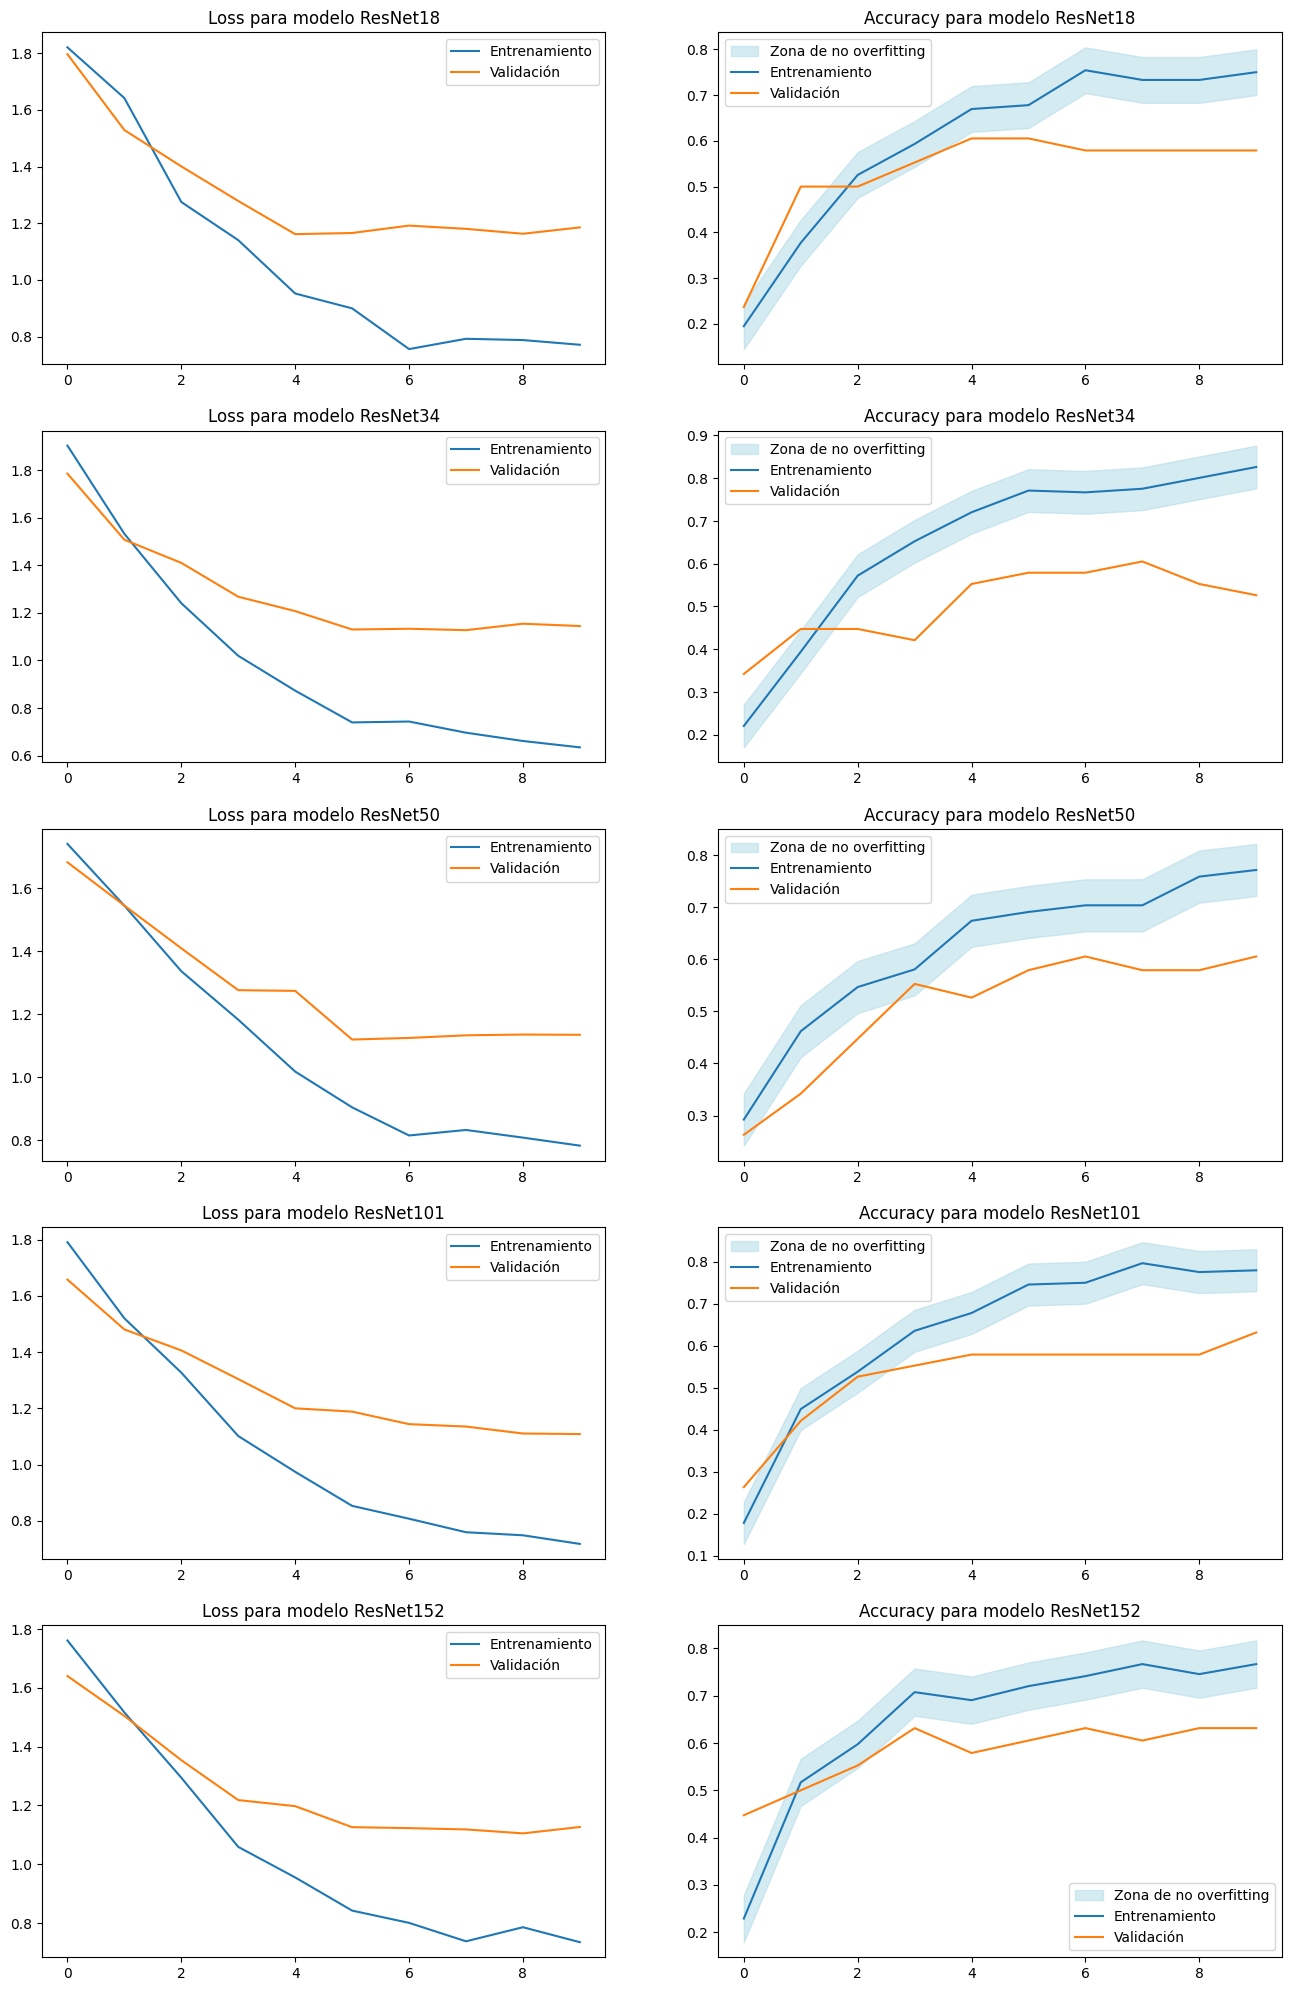

In [9]:
fig, axs = plt.subplots(nrows=len(num_model), ncols=2, figsize=(16,25))

loss = axs[:, 0]
acc = axs[:, 1]

for i, num in enumerate(num_model):
    loss[i].plot(train_loss_resnet[i], label='Entrenamiento')
    loss[i].plot(val_loss_resnet[i], label='Validación')

    train_acc_resnet[i] = [value.cpu().detach().numpy() for value in train_acc_resnet[i]]
    val_acc_resnet[i] = [value.cpu().detach().numpy() for value in val_acc_resnet[i]]

    lower_bound = [value - 0.05 for value in train_acc_resnet[i]]
    upper_bound = [value + 0.05 for value in train_acc_resnet[i]]

    acc[i].fill_between(list(range(num_epochs)), lower_bound, upper_bound, color='lightblue', alpha=0.5, label='Zona de no overfitting')

    acc[i].plot(train_acc_resnet[i], label='Entrenamiento')
    acc[i].plot(val_acc_resnet[i], label='Validación')

    loss[i].set_title(f"Loss para modelo ResNet{num}")
    acc[i].set_title(f"Accuracy para modelo ResNet{num}")

    loss[i].legend()
    acc[i].legend()

plt.show()

In [10]:
# Predecimos
for i, num in enumerate(num_model):
    model = models_resnet[i]
    model.eval()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model.to(device)

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    print(f'Test Accuracy para ResNet{num}: {accuracy:.2f}%')

Test Accuracy para ResNet18: 64.86%
Test Accuracy para ResNet34: 44.59%
Test Accuracy para ResNet50: 58.11%
Test Accuracy para ResNet101: 58.11%
Test Accuracy para ResNet152: 58.11%


## VGG

In [11]:
num_model = [11, 13, 16, 19]
models_vgg, train_loss_vgg, train_acc_vgg, val_loss_vgg, val_acc_vgg = [], [], [], [], []
num_epochs = 10

for num in num_model:
    name = f"models.vgg{num}"

    model_ft = eval(name)(pretrained=True)

    num_ft = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ft, 6)

    model_ft = model_ft.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    print(f"Modelo VGG{num}")
    model_ft, train_loss, train_acc, val_loss, val_acc = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

    models_vgg.append(model_ft)
    train_loss_vgg.append(train_loss)
    train_acc_vgg.append(train_acc)
    val_loss_vgg.append(val_loss)
    val_acc_vgg.append(val_acc)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:06<00:00, 81.7MB/s]


Modelo VGG11
Epoch 1/10
----------
Train Loss: 1.7724 Acc: 0.2373
Val Loss: 1.5784 Acc: 0.3421

Epoch 2/10
----------
Train Loss: 1.5165 Acc: 0.4449
Val Loss: 1.3792 Acc: 0.5000

Epoch 3/10
----------
Train Loss: 1.2381 Acc: 0.5339
Val Loss: 1.2092 Acc: 0.5526

Epoch 4/10
----------
Train Loss: 1.0850 Acc: 0.5805
Val Loss: 1.3312 Acc: 0.5263

Epoch 5/10
----------
Train Loss: 0.9409 Acc: 0.7034
Val Loss: 1.1867 Acc: 0.5789

Epoch 6/10
----------
Train Loss: 0.8621 Acc: 0.6907
Val Loss: 1.0772 Acc: 0.5526

Epoch 7/10
----------
Train Loss: 0.6806 Acc: 0.7627
Val Loss: 1.0634 Acc: 0.5526

Epoch 8/10
----------
Train Loss: 0.7127 Acc: 0.7500
Val Loss: 1.0513 Acc: 0.5526

Epoch 9/10
----------
Train Loss: 0.7734 Acc: 0.7246
Val Loss: 1.0432 Acc: 0.5526

Epoch 10/10
----------
Train Loss: 0.6937 Acc: 0.7415
Val Loss: 1.0109 Acc: 0.5526

Training complete in 0m 30s
Best val accuracy: 0.5526



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG13_Weights.IMAGENET1K_V1`. You can also use `weights=VGG13_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg13-19584684.pth" to /root/.cache/torch/hub/checkpoints/vgg13-19584684.pth
100%|██████████| 508M/508M [00:06<00:00, 79.5MB/s]


Modelo VGG13
Epoch 1/10
----------
Train Loss: 1.8153 Acc: 0.1822
Val Loss: 1.5515 Acc: 0.4211

Epoch 2/10
----------
Train Loss: 1.4390 Acc: 0.4746
Val Loss: 1.4267 Acc: 0.4737

Epoch 3/10
----------
Train Loss: 1.2891 Acc: 0.5085
Val Loss: 1.3753 Acc: 0.5000

Epoch 4/10
----------
Train Loss: 1.1129 Acc: 0.5805
Val Loss: 1.2819 Acc: 0.5789

Epoch 5/10
----------
Train Loss: 0.9694 Acc: 0.5975
Val Loss: 1.2797 Acc: 0.5263

Epoch 6/10
----------
Train Loss: 0.8351 Acc: 0.7246
Val Loss: 1.1993 Acc: 0.5263

Epoch 7/10
----------
Train Loss: 0.7488 Acc: 0.7288
Val Loss: 1.2027 Acc: 0.5000

Epoch 8/10
----------
Train Loss: 0.7494 Acc: 0.7034
Val Loss: 1.2296 Acc: 0.5526

Epoch 9/10
----------
Train Loss: 0.8173 Acc: 0.7034
Val Loss: 1.2575 Acc: 0.5789

Epoch 10/10
----------
Train Loss: 0.7389 Acc: 0.7585
Val Loss: 1.2828 Acc: 0.5789

Training complete in 0m 41s
Best val accuracy: 0.5789



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 88.3MB/s]


Modelo VGG16
Epoch 1/10
----------
Train Loss: 1.7770 Acc: 0.1907
Val Loss: 1.5966 Acc: 0.3158

Epoch 2/10
----------
Train Loss: 1.5502 Acc: 0.4280
Val Loss: 1.4200 Acc: 0.5526

Epoch 3/10
----------
Train Loss: 1.3357 Acc: 0.5254
Val Loss: 1.2881 Acc: 0.5263

Epoch 4/10
----------
Train Loss: 1.1614 Acc: 0.5508
Val Loss: 1.2100 Acc: 0.5789

Epoch 5/10
----------
Train Loss: 0.9226 Acc: 0.6483
Val Loss: 1.3480 Acc: 0.5526

Epoch 6/10
----------
Train Loss: 0.8166 Acc: 0.6695
Val Loss: 1.2146 Acc: 0.5789

Epoch 7/10
----------
Train Loss: 0.7667 Acc: 0.7246
Val Loss: 1.1997 Acc: 0.6316

Epoch 8/10
----------
Train Loss: 0.7346 Acc: 0.7458
Val Loss: 1.1999 Acc: 0.6316

Epoch 9/10
----------
Train Loss: 0.6970 Acc: 0.7542
Val Loss: 1.1826 Acc: 0.6053

Epoch 10/10
----------
Train Loss: 0.7139 Acc: 0.7415
Val Loss: 1.1935 Acc: 0.5789

Training complete in 0m 47s
Best val accuracy: 0.5789



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 96.8MB/s]


Modelo VGG19
Epoch 1/10
----------
Train Loss: 1.7123 Acc: 0.2881
Val Loss: 1.5461 Acc: 0.3684

Epoch 2/10
----------
Train Loss: 1.3846 Acc: 0.4492
Val Loss: 1.3630 Acc: 0.4211

Epoch 3/10
----------
Train Loss: 1.1689 Acc: 0.5593
Val Loss: 1.4881 Acc: 0.4474

Epoch 4/10
----------
Train Loss: 0.9253 Acc: 0.6483
Val Loss: 1.1186 Acc: 0.6316

Epoch 5/10
----------
Train Loss: 0.6958 Acc: 0.7924
Val Loss: 1.2540 Acc: 0.5789

Epoch 6/10
----------
Train Loss: 0.6906 Acc: 0.7373
Val Loss: 1.1376 Acc: 0.6316

Epoch 7/10
----------
Train Loss: 0.6364 Acc: 0.7542
Val Loss: 1.1786 Acc: 0.6053

Epoch 8/10
----------
Train Loss: 0.6349 Acc: 0.7712
Val Loss: 1.2325 Acc: 0.6053

Epoch 9/10
----------
Train Loss: 0.5484 Acc: 0.8093
Val Loss: 1.2688 Acc: 0.6316

Epoch 10/10
----------
Train Loss: 0.5645 Acc: 0.7924
Val Loss: 1.1778 Acc: 0.5789

Training complete in 0m 53s
Best val accuracy: 0.6316



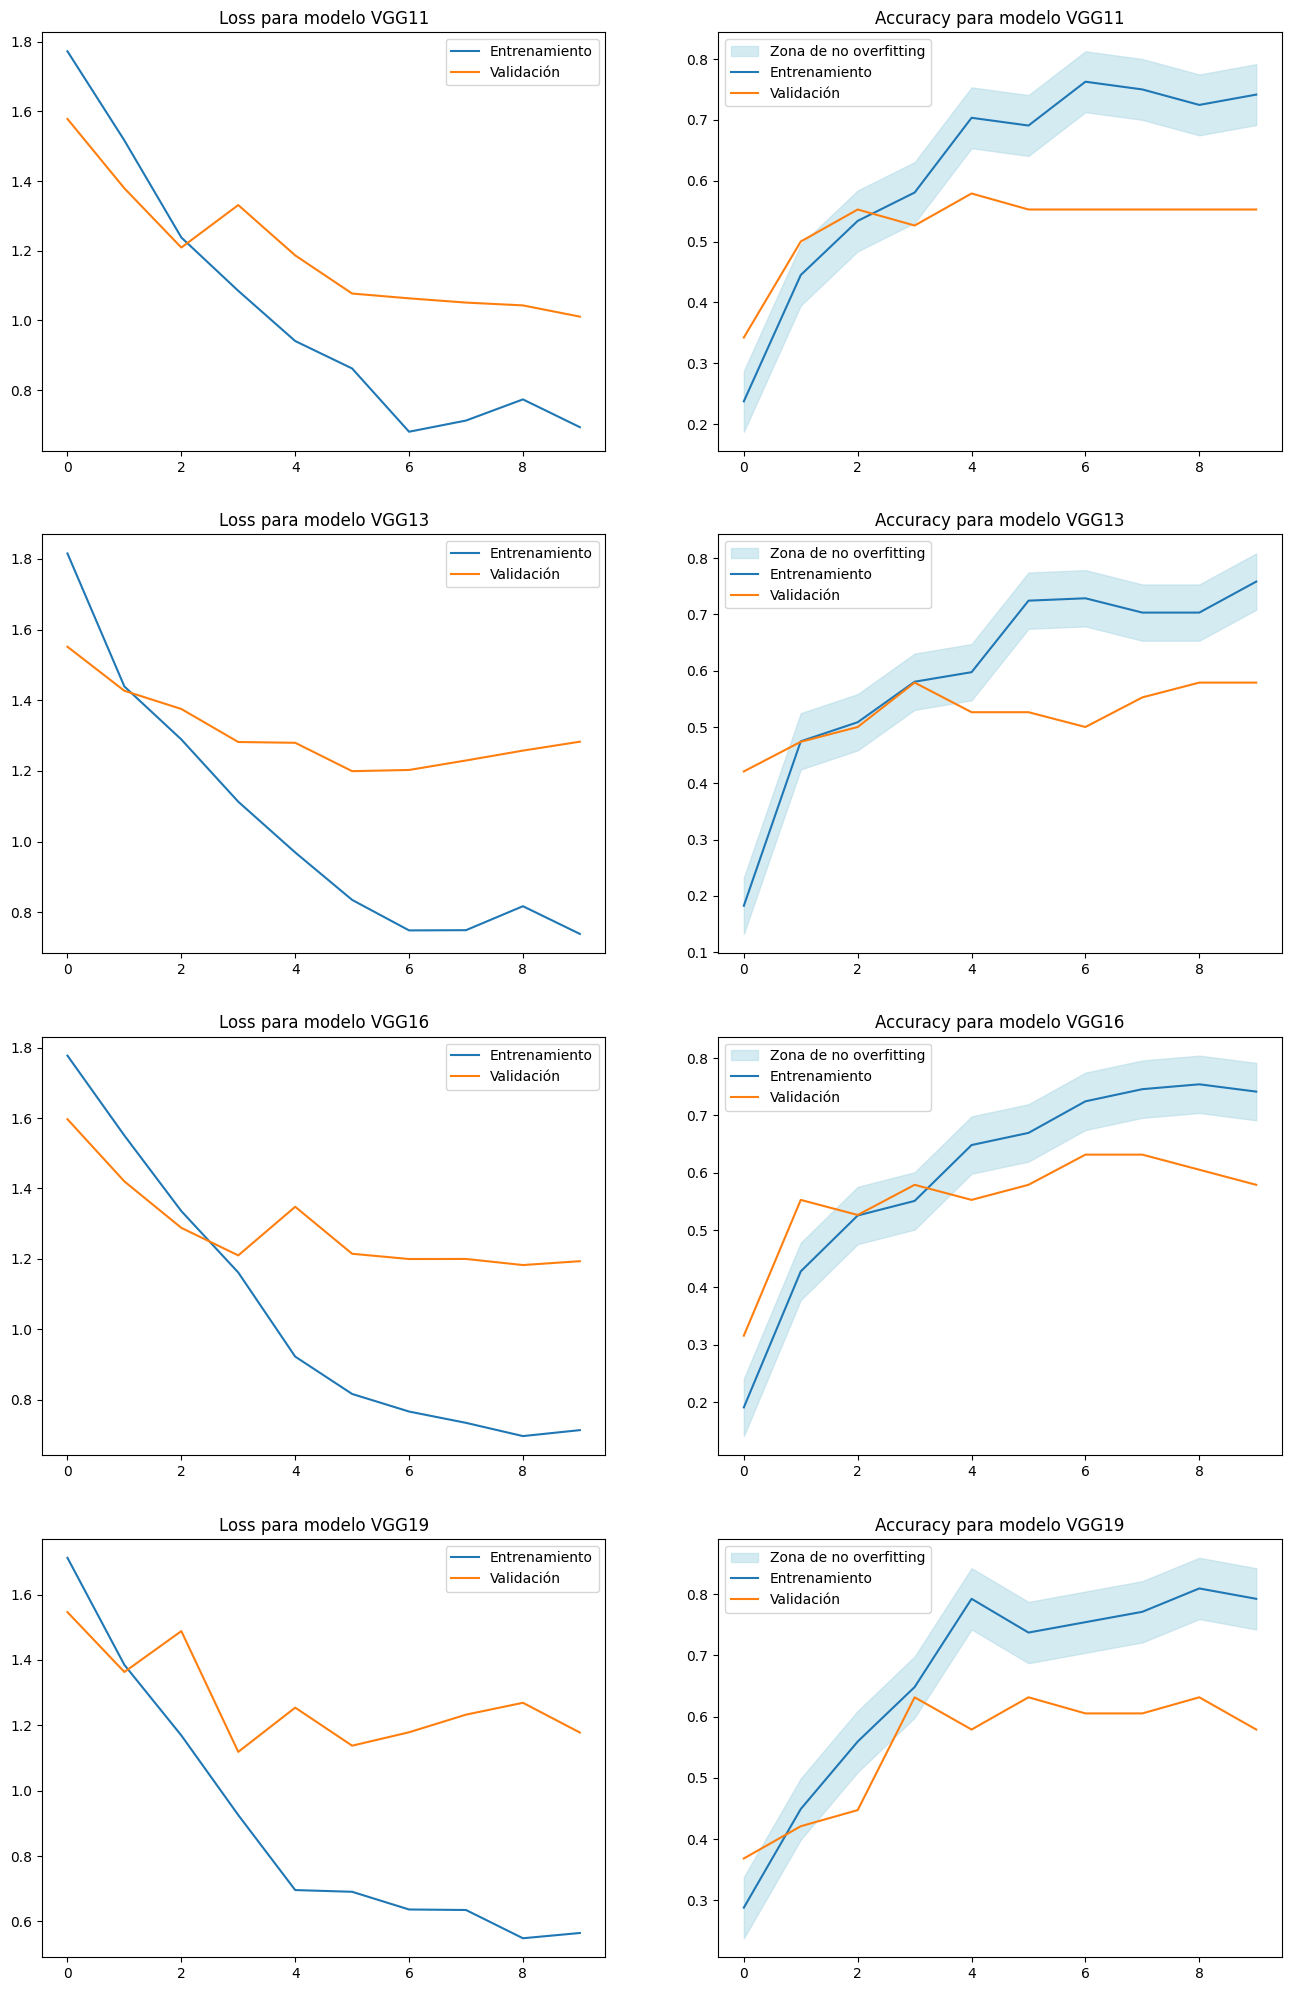

In [12]:
fig, axs = plt.subplots(nrows=len(num_model), ncols=2, figsize=(16,25))

loss = axs[:, 0]
acc = axs[:, 1]

for i, num in enumerate(num_model):
    loss[i].plot(train_loss_vgg[i], label='Entrenamiento')
    loss[i].plot(val_loss_vgg[i], label='Validación')

    train_acc_vgg[i] = [value.cpu().detach().numpy() for value in train_acc_vgg[i]]
    val_acc_vgg[i] = [value.cpu().detach().numpy() for value in val_acc_vgg[i]]

    lower_bound = [value - 0.05 for value in train_acc_vgg[i]]
    upper_bound = [value + 0.05 for value in train_acc_vgg[i]]

    acc[i].fill_between(list(range(num_epochs)), lower_bound, upper_bound, color='lightblue', alpha=0.5, label='Zona de no overfitting')

    acc[i].plot(train_acc_vgg[i], label='Entrenamiento')
    acc[i].plot(val_acc_vgg[i], label='Validación')

    loss[i].set_title(f"Loss para modelo VGG{num}")
    acc[i].set_title(f"Accuracy para modelo VGG{num}")

    loss[i].legend()
    acc[i].legend()

plt.show()

In [13]:
# Predecimos
for i, num in enumerate(num_model):
    model = models_vgg[i]
    model.eval()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model.to(device)

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    print(f'Test Accuracy para VGG{num}: {accuracy:.2f}%')

Test Accuracy para VGG11: 58.11%
Test Accuracy para VGG13: 68.92%
Test Accuracy para VGG16: 60.81%
Test Accuracy para VGG19: 70.27%


## DenseNet

In [14]:
num_model = [121, 161, 169, 201]
models_densenet, train_loss_densenet, train_acc_densenet, val_loss_densenet, val_acc_densenet = [], [], [], [], []
num_epochs = 10

for num in num_model:
    name = f"models.densenet{num}"

    model_ft = eval(name)(pretrained=True)

    num_ft = model_ft.classifier.in_features
    model_ft.classifier = nn.Linear(num_ft, 6)

    model_ft = model_ft.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    print(f"Modelo DenseNet{num}")
    model_ft, train_loss, train_acc, val_loss, val_acc = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

    models_densenet.append(model_ft)
    train_loss_densenet.append(train_loss)
    train_acc_densenet.append(train_acc)
    val_loss_densenet.append(val_loss)
    val_acc_densenet.append(val_acc)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 133MB/s]


Modelo DenseNet121
Epoch 1/10
----------
Train Loss: 1.7409 Acc: 0.2246
Val Loss: 1.7750 Acc: 0.2632

Epoch 2/10
----------
Train Loss: 1.5043 Acc: 0.4449
Val Loss: 1.6600 Acc: 0.3684

Epoch 3/10
----------
Train Loss: 1.2928 Acc: 0.5975
Val Loss: 1.4636 Acc: 0.5000

Epoch 4/10
----------
Train Loss: 1.0965 Acc: 0.6610
Val Loss: 1.3818 Acc: 0.5000

Epoch 5/10
----------
Train Loss: 0.9735 Acc: 0.6864
Val Loss: 1.2654 Acc: 0.5000

Epoch 6/10
----------
Train Loss: 0.8633 Acc: 0.7288
Val Loss: 1.3630 Acc: 0.5000

Epoch 7/10
----------
Train Loss: 0.7802 Acc: 0.7542
Val Loss: 1.3063 Acc: 0.4737

Epoch 8/10
----------
Train Loss: 0.7693 Acc: 0.7458
Val Loss: 1.2643 Acc: 0.5000

Epoch 9/10
----------
Train Loss: 0.8051 Acc: 0.7288
Val Loss: 1.2437 Acc: 0.5526

Epoch 10/10
----------
Train Loss: 0.7283 Acc: 0.7881
Val Loss: 1.2288 Acc: 0.5789

Training complete in 0m 37s
Best val accuracy: 0.2632



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:01<00:00, 105MB/s] 


Modelo DenseNet161
Epoch 1/10
----------
Train Loss: 1.7416 Acc: 0.2373
Val Loss: 1.5715 Acc: 0.3947

Epoch 2/10
----------
Train Loss: 1.4923 Acc: 0.4322
Val Loss: 1.4302 Acc: 0.4474

Epoch 3/10
----------
Train Loss: 1.2854 Acc: 0.5297
Val Loss: 1.2889 Acc: 0.4474

Epoch 4/10
----------
Train Loss: 1.0658 Acc: 0.6907
Val Loss: 1.3643 Acc: 0.4737

Epoch 5/10
----------
Train Loss: 0.9215 Acc: 0.6949
Val Loss: 1.3051 Acc: 0.5263

Epoch 6/10
----------
Train Loss: 0.8232 Acc: 0.7754
Val Loss: 1.2259 Acc: 0.5789

Epoch 7/10
----------
Train Loss: 0.7541 Acc: 0.7966
Val Loss: 1.2282 Acc: 0.5789

Epoch 8/10
----------
Train Loss: 0.7573 Acc: 0.8008
Val Loss: 1.2002 Acc: 0.5789

Epoch 9/10
----------
Train Loss: 0.7585 Acc: 0.7797
Val Loss: 1.2058 Acc: 0.5526

Epoch 10/10
----------
Train Loss: 0.6744 Acc: 0.8178
Val Loss: 1.1860 Acc: 0.5526

Training complete in 1m 6s
Best val accuracy: 0.4474



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 126MB/s]


Modelo DenseNet169
Epoch 1/10
----------
Train Loss: 1.8444 Acc: 0.1907
Val Loss: 1.7089 Acc: 0.3947

Epoch 2/10
----------
Train Loss: 1.6001 Acc: 0.4322
Val Loss: 1.5970 Acc: 0.4474

Epoch 3/10
----------
Train Loss: 1.2992 Acc: 0.5424
Val Loss: 1.4875 Acc: 0.3421

Epoch 4/10
----------
Train Loss: 1.1076 Acc: 0.6525
Val Loss: 1.3812 Acc: 0.4474

Epoch 5/10
----------
Train Loss: 0.9553 Acc: 0.6907
Val Loss: 1.2146 Acc: 0.5000

Epoch 6/10
----------
Train Loss: 0.8624 Acc: 0.7458
Val Loss: 1.2067 Acc: 0.6053

Epoch 7/10
----------
Train Loss: 0.7827 Acc: 0.7754
Val Loss: 1.2089 Acc: 0.5789

Epoch 8/10
----------
Train Loss: 0.7755 Acc: 0.7627
Val Loss: 1.1837 Acc: 0.5789

Epoch 9/10
----------
Train Loss: 0.7180 Acc: 0.7881
Val Loss: 1.1793 Acc: 0.6053

Epoch 10/10
----------
Train Loss: 0.7448 Acc: 0.7881
Val Loss: 1.1710 Acc: 0.6053

Training complete in 0m 43s
Best val accuracy: 0.4474



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 100MB/s] 


Modelo DenseNet201
Epoch 1/10
----------
Train Loss: 1.7857 Acc: 0.2161
Val Loss: 1.6385 Acc: 0.3421

Epoch 2/10
----------
Train Loss: 1.5532 Acc: 0.3644
Val Loss: 1.5245 Acc: 0.3684

Epoch 3/10
----------
Train Loss: 1.3102 Acc: 0.5339
Val Loss: 1.3437 Acc: 0.5263

Epoch 4/10
----------
Train Loss: 1.1370 Acc: 0.6356
Val Loss: 1.3289 Acc: 0.5000

Epoch 5/10
----------
Train Loss: 0.9676 Acc: 0.6992
Val Loss: 1.2858 Acc: 0.5526

Epoch 6/10
----------
Train Loss: 0.8278 Acc: 0.7500
Val Loss: 1.2248 Acc: 0.5000

Epoch 7/10
----------
Train Loss: 0.7789 Acc: 0.7585
Val Loss: 1.2050 Acc: 0.5000

Epoch 8/10
----------
Train Loss: 0.7223 Acc: 0.7924
Val Loss: 1.1970 Acc: 0.5526

Epoch 9/10
----------
Train Loss: 0.7127 Acc: 0.7839
Val Loss: 1.2204 Acc: 0.5526

Epoch 10/10
----------
Train Loss: 0.7108 Acc: 0.8220
Val Loss: 1.1978 Acc: 0.5789

Training complete in 0m 53s
Best val accuracy: 0.5263



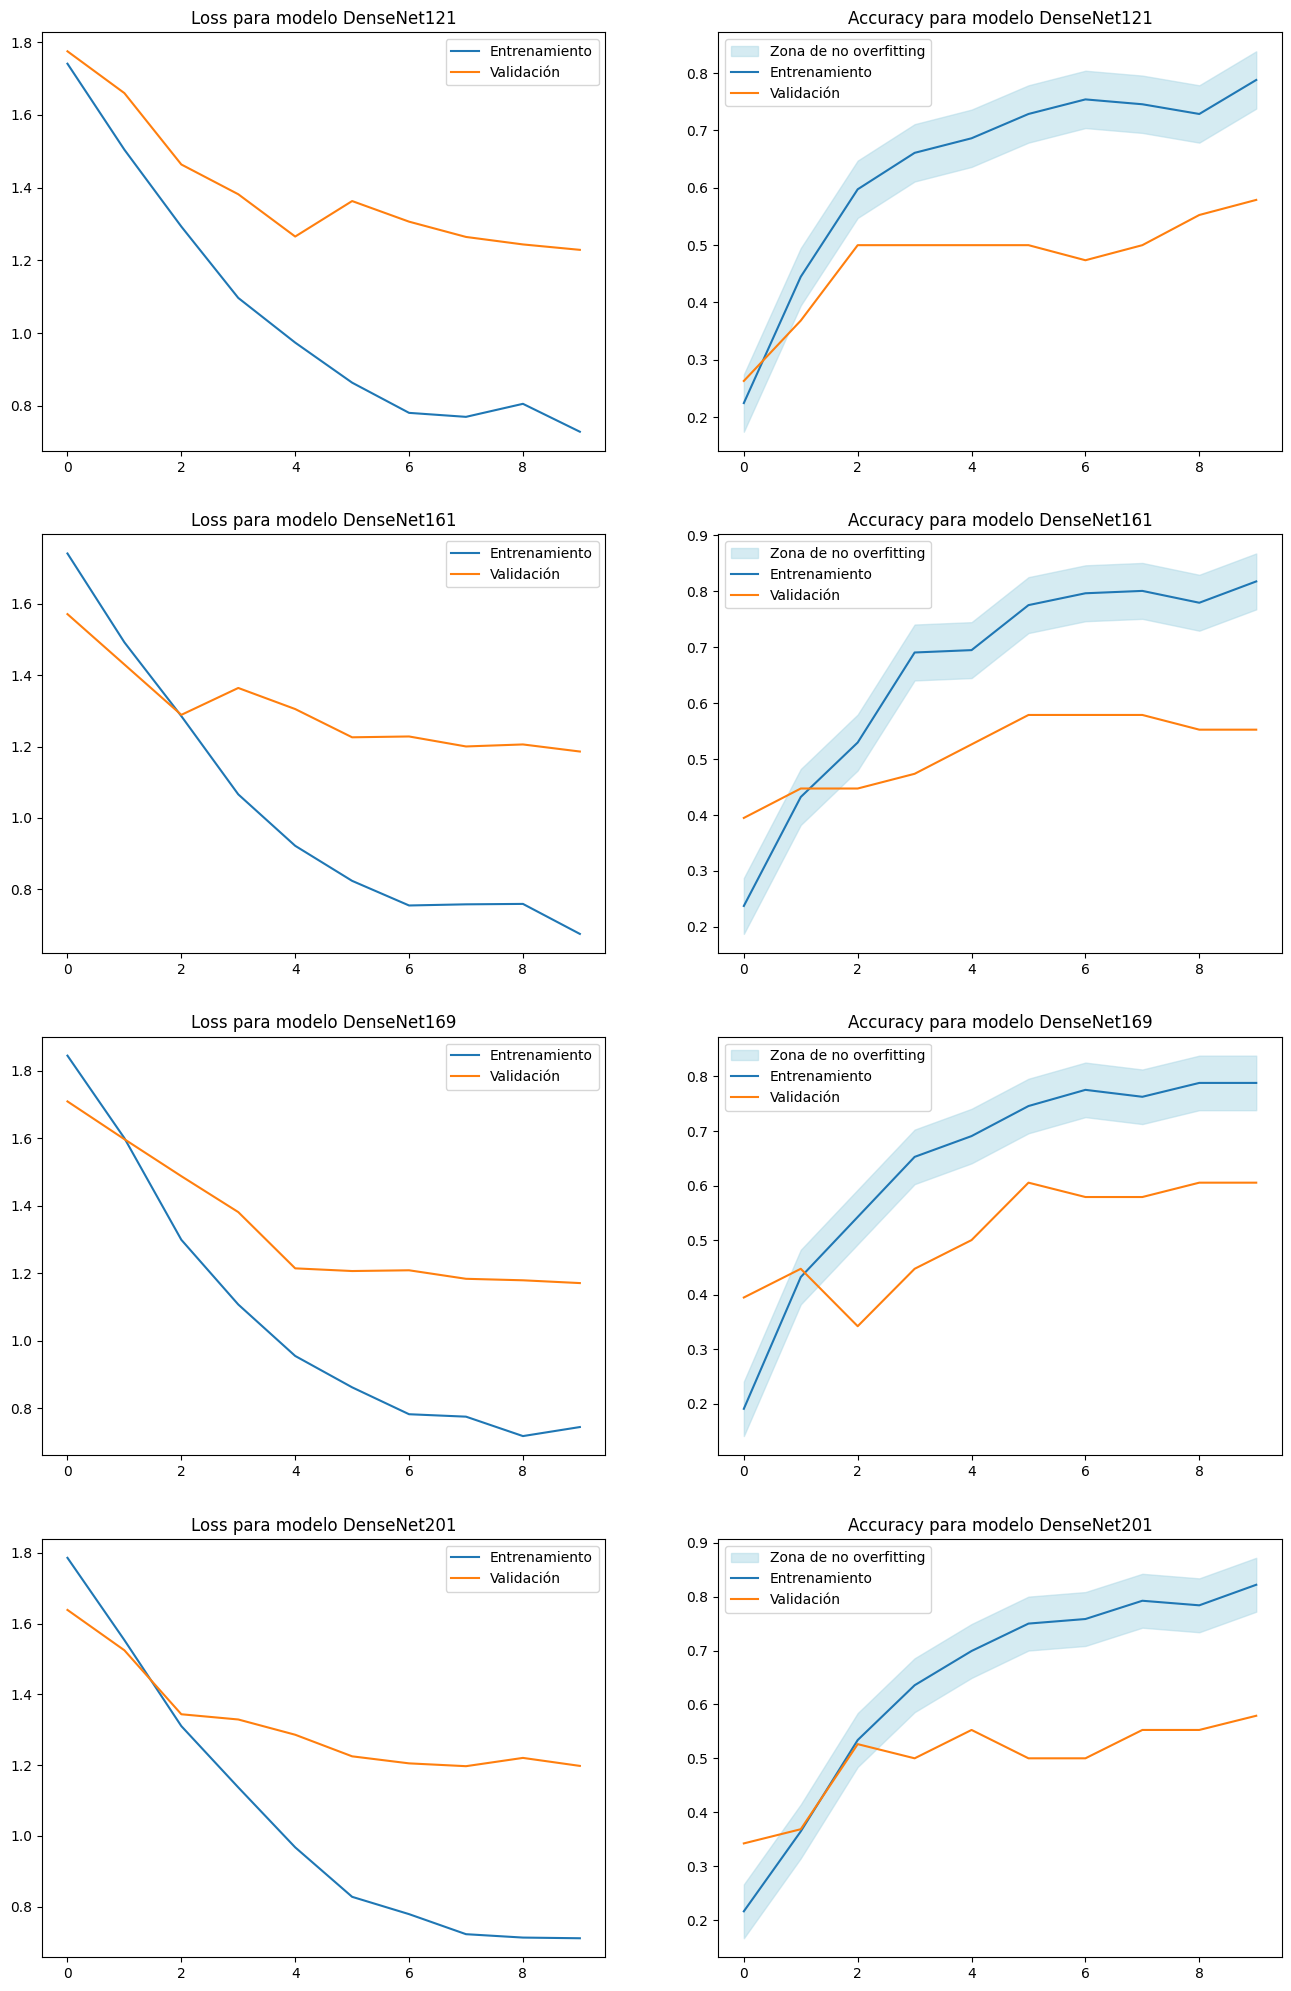

In [15]:
fig, axs = plt.subplots(nrows=len(num_model), ncols=2, figsize=(16,25))

loss = axs[:, 0]
acc = axs[:, 1]

for i, num in enumerate(num_model):
    loss[i].plot(train_loss_densenet[i], label='Entrenamiento')
    loss[i].plot(val_loss_densenet[i], label='Validación')

    train_acc_densenet[i] = [value.cpu().detach().numpy() for value in train_acc_densenet[i]]
    val_acc_densenet[i] = [value.cpu().detach().numpy() for value in val_acc_densenet[i]]

    lower_bound = [value - 0.05 for value in train_acc_densenet[i]]
    upper_bound = [value + 0.05 for value in train_acc_densenet[i]]

    acc[i].fill_between(list(range(num_epochs)), lower_bound, upper_bound, color='lightblue', alpha=0.5, label='Zona de no overfitting')

    acc[i].plot(train_acc_densenet[i], label='Entrenamiento')
    acc[i].plot(val_acc_densenet[i], label='Validación')

    loss[i].set_title(f"Loss para modelo DenseNet{num}")
    acc[i].set_title(f"Accuracy para modelo DenseNet{num}")

    loss[i].legend()
    acc[i].legend()

plt.show()

In [16]:
# Predecimos
for i, num in enumerate(num_model):
    model = models_densenet[i]
    model.eval()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model.to(device)

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    print(f'Test Accuracy para DenseNet{num}: {accuracy:.2f}%')

Test Accuracy para DenseNet121: 32.43%
Test Accuracy para DenseNet161: 48.65%
Test Accuracy para DenseNet169: 48.65%
Test Accuracy para DenseNet201: 56.76%


>Hemos analizado tres modelos distintos: ResNet, VGG y DenseNet, cambiando el número de capas. Cada modelo fue entrenado durante diez (10) épocas, y se guardaron los pesos en la épocas donde aumentaba el accuracy en el conjunto de validación y no existía overfitting.
>
>Podemos ver que el modelo ResNet18 y los modelos VGG presentan el mayor accuracy en el conjunto de prueba, y evitan el overfitting, siendo VGG19 el más alto (70.27% de accuracy). Esto puede explicarse ya que la cantidad de datos que tenemos es baja, por lo que no necesitamos un modelo muy complejo. Además, las curvas de la loss son más suaves en comparación al modelo DenseNet, precisamente porque DenseNet funciona con muchas capas, provocando que el modelo sea más propenso a overfitting.

# Solución 2: Freezing

Utiliza freezing para el problema anterior y reporta el accuracy de test. Intenta obtener el accuracy de test más alto posible, sin que el modelo haga overfitting. Considera overfitting cuando la diferencia entre accuracy de train y accuracy de validación tengan una diferencia de más de 5%.

## ResNet

In [17]:
num_model = [18, 34, 50, 101, 152]
models_resnet, train_loss_resnet, train_acc_resnet, val_loss_resnet, val_acc_resnet= [], [], [], [], []
num_epochs = 10

for num in num_model:
    name = f"torchvision.models.resnet{num}"

    model_conv = eval(name)(pretrained=True)
    for param in model_conv.parameters():
        param.requires_grad = False

    num_ft = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ft, 6)

    model_conv = model_conv.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_conv = torch.optim.SGD(model_conv.fc.parameters(), lr = 0.001, momentum=0.9)
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma = 0.1)

    print(f"Modelo ResNet{num}")
    model_conv, train_loss, train_acc, val_loss, val_acc = train_model(model_conv, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

    models_resnet.append(model_conv)
    train_loss_resnet.append(train_loss)
    train_acc_resnet.append(train_acc)
    val_loss_resnet.append(val_loss)
    val_acc_resnet.append(val_acc)

Modelo ResNet18
Epoch 1/10
----------
Train Loss: 1.9569 Acc: 0.1398
Val Loss: 1.7776 Acc: 0.3158

Epoch 2/10
----------
Train Loss: 1.9380 Acc: 0.1229
Val Loss: 1.7840 Acc: 0.3158

Epoch 3/10
----------
Train Loss: 1.9456 Acc: 0.1356
Val Loss: 1.8121 Acc: 0.2632

Epoch 4/10
----------
Train Loss: 2.0105 Acc: 0.1525
Val Loss: 1.8477 Acc: 0.2632

Epoch 5/10
----------
Train Loss: 1.9697 Acc: 0.1695
Val Loss: 1.8588 Acc: 0.2632

Epoch 6/10
----------
Train Loss: 1.9964 Acc: 0.1314
Val Loss: 1.8614 Acc: 0.2368

Epoch 7/10
----------
Train Loss: 1.9671 Acc: 0.1271
Val Loss: 1.8590 Acc: 0.2105

Epoch 8/10
----------
Train Loss: 1.9921 Acc: 0.1144
Val Loss: 1.8664 Acc: 0.1842

Epoch 9/10
----------
Train Loss: 1.9651 Acc: 0.1483
Val Loss: 1.8694 Acc: 0.1842

Epoch 10/10
----------
Train Loss: 1.9610 Acc: 0.1568
Val Loss: 1.8735 Acc: 0.1579

Training complete in 0m 17s
Best val accuracy: 0.3158

Modelo ResNet34
Epoch 1/10
----------
Train Loss: 2.1842 Acc: 0.1525
Val Loss: 2.0590 Acc: 0.1579


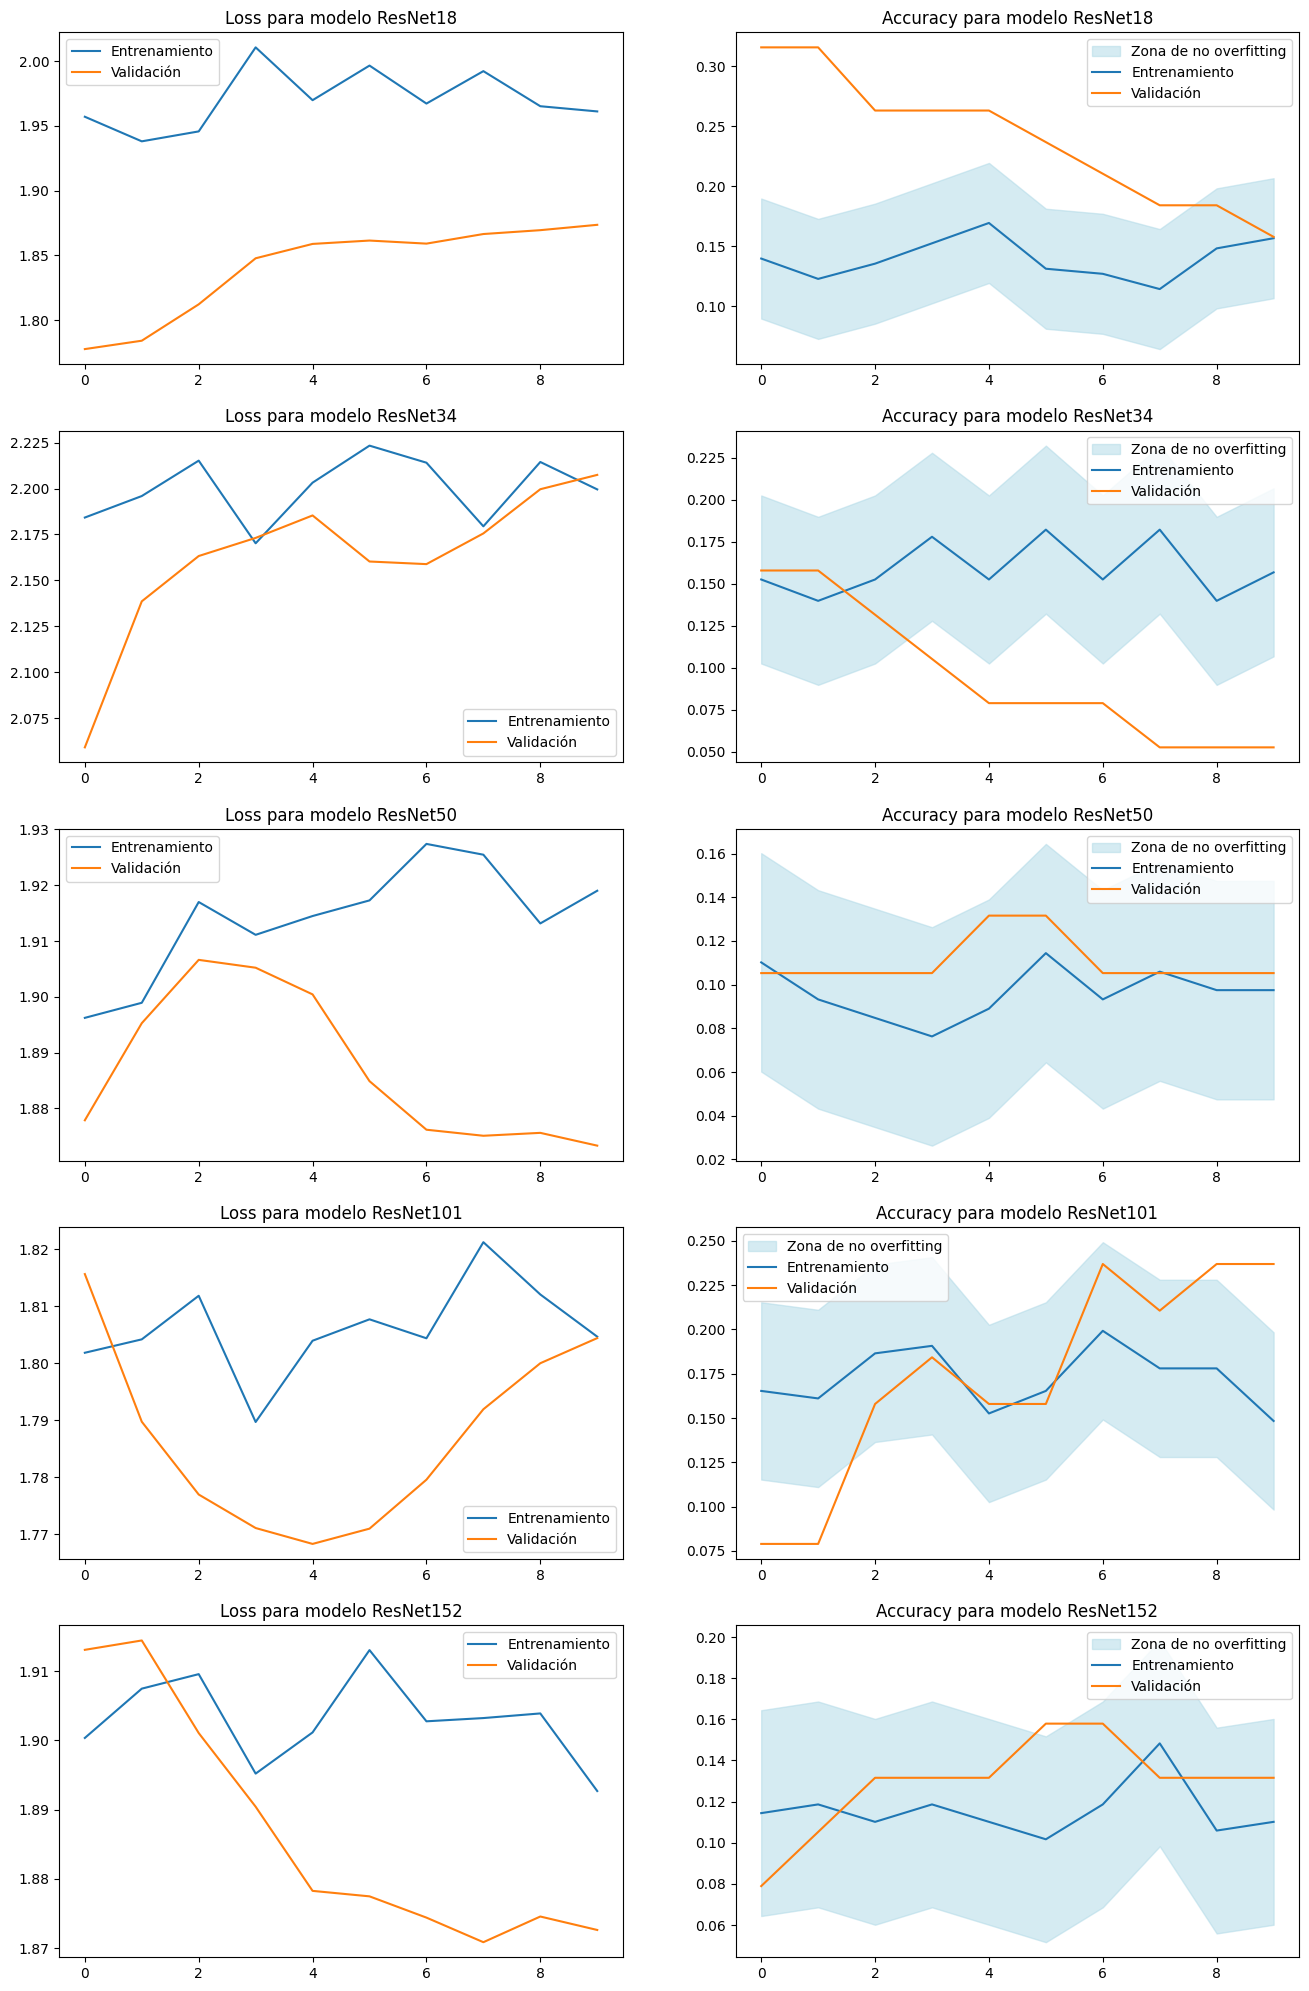

In [18]:
fig, axs = plt.subplots(nrows=len(num_model), ncols=2, figsize=(16,25))

loss = axs[:, 0]
acc = axs[:, 1]

for i, num in enumerate(num_model):
    loss[i].plot(train_loss_resnet[i], label='Entrenamiento')
    loss[i].plot(val_loss_resnet[i], label='Validación')

    train_acc_resnet[i] = [value.cpu().detach().numpy() for value in train_acc_resnet[i]]
    val_acc_resnet[i] = [value.cpu().detach().numpy() for value in val_acc_resnet[i]]

    lower_bound = [value - 0.05 for value in train_acc_resnet[i]]
    upper_bound = [value + 0.05 for value in train_acc_resnet[i]]

    acc[i].fill_between(list(range(num_epochs)), lower_bound, upper_bound, color='lightblue', alpha=0.5, label='Zona de no overfitting')

    acc[i].plot(train_acc_resnet[i], label='Entrenamiento')
    acc[i].plot(val_acc_resnet[i], label='Validación')

    loss[i].set_title(f"Loss para modelo ResNet{num}")
    acc[i].set_title(f"Accuracy para modelo ResNet{num}")

    loss[i].legend()
    acc[i].legend()

plt.show()

In [19]:
# Predecimos
for i, num in enumerate(num_model):
    model = models_resnet[i]
    model.eval()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model.to(device)

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    print(f'Test Accuracy para ResNet{num}: {accuracy:.2f}%')

Test Accuracy para ResNet18: 17.57%
Test Accuracy para ResNet34: 12.16%
Test Accuracy para ResNet50: 13.51%
Test Accuracy para ResNet101: 12.16%
Test Accuracy para ResNet152: 13.51%


## VGG

In [20]:
num_model = [11, 13, 16, 19]
models_vgg, train_loss_vgg, train_acc_vgg, val_loss_vgg, val_acc_vgg = [], [], [], [], []
num_epochs = 10

for num in num_model:
    name = f"torchvision.models.vgg{num}"

    model_conv = eval(name)(pretrained=True)
    for param in model_conv.parameters():
        param.requires_grad = False

    num_ft = model_conv.classifier[6].in_features
    model_conv.classifier[6] = nn.Linear(num_ft, 6)

    model_conv = model_conv.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_conv = torch.optim.SGD(model_conv.classifier[6].parameters(), lr = 0.001, momentum=0.9)
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma = 0.1)

    print(f"Modelo VGG{num}")
    model_conv, train_loss, train_acc, val_loss, val_acc = train_model(model_conv, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

    models_vgg.append(model_conv)
    train_loss_vgg.append(train_loss)
    train_acc_vgg.append(train_acc)
    val_loss_vgg.append(val_loss)
    val_acc_vgg.append(val_acc)

Modelo VGG11
Epoch 1/10
----------
Train Loss: 1.8982 Acc: 0.1610
Val Loss: 1.7617 Acc: 0.2895

Epoch 2/10
----------
Train Loss: 1.8860 Acc: 0.1610
Val Loss: 1.7617 Acc: 0.2895

Epoch 3/10
----------
Train Loss: 1.8813 Acc: 0.2034
Val Loss: 1.7617 Acc: 0.2895

Epoch 4/10
----------
Train Loss: 1.8935 Acc: 0.1907
Val Loss: 1.7617 Acc: 0.2895

Epoch 5/10
----------
Train Loss: 1.8626 Acc: 0.1907
Val Loss: 1.7617 Acc: 0.2895

Epoch 6/10
----------
Train Loss: 1.8981 Acc: 0.1695
Val Loss: 1.7617 Acc: 0.2895

Epoch 7/10
----------
Train Loss: 1.8484 Acc: 0.1525
Val Loss: 1.7617 Acc: 0.2895

Epoch 8/10
----------
Train Loss: 1.8943 Acc: 0.1864
Val Loss: 1.7617 Acc: 0.2895

Epoch 9/10
----------
Train Loss: 1.8895 Acc: 0.1992
Val Loss: 1.7617 Acc: 0.2895

Epoch 10/10
----------
Train Loss: 1.8762 Acc: 0.1695
Val Loss: 1.7617 Acc: 0.2895

Training complete in 0m 19s
Best val accuracy: 0.2895

Modelo VGG13
Epoch 1/10
----------
Train Loss: 1.8876 Acc: 0.1525
Val Loss: 1.9148 Acc: 0.0789

Epoch

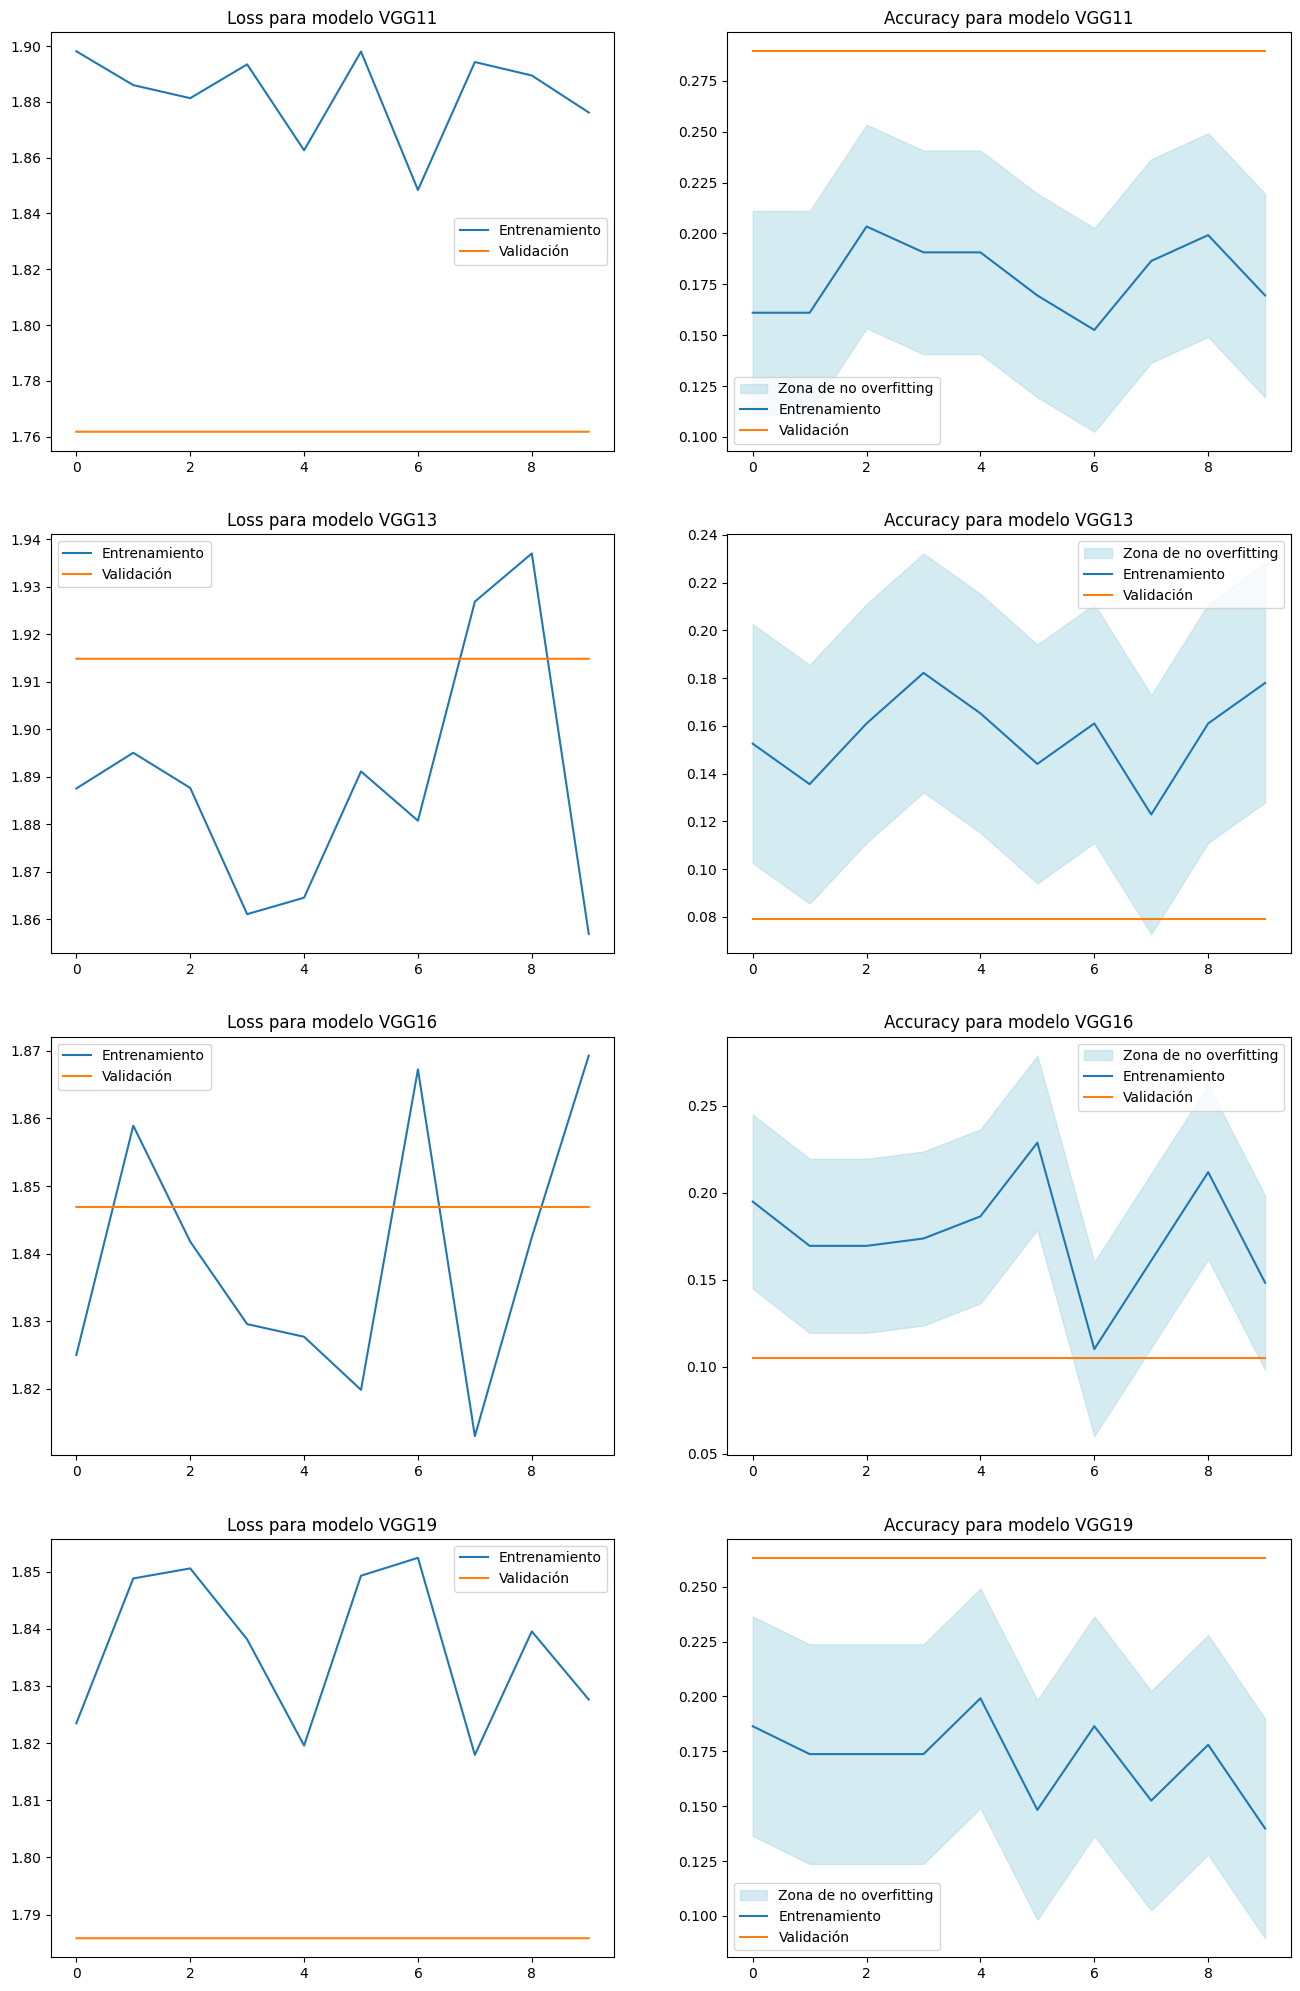

In [21]:
fig, axs = plt.subplots(nrows=len(num_model), ncols=2, figsize=(16,25))

loss = axs[:, 0]
acc = axs[:, 1]

for i, num in enumerate(num_model):
    loss[i].plot(train_loss_vgg[i], label='Entrenamiento')
    loss[i].plot(val_loss_vgg[i], label='Validación')

    train_acc_vgg[i] = [value.cpu().detach().numpy() for value in train_acc_vgg[i]]
    val_acc_vgg[i] = [value.cpu().detach().numpy() for value in val_acc_vgg[i]]

    lower_bound = [value - 0.05 for value in train_acc_vgg[i]]
    upper_bound = [value + 0.05 for value in train_acc_vgg[i]]

    acc[i].fill_between(list(range(num_epochs)), lower_bound, upper_bound, color='lightblue', alpha=0.5, label='Zona de no overfitting')

    acc[i].plot(train_acc_vgg[i], label='Entrenamiento')
    acc[i].plot(val_acc_vgg[i], label='Validación')

    loss[i].set_title(f"Loss para modelo VGG{num}")
    acc[i].set_title(f"Accuracy para modelo VGG{num}")

    loss[i].legend()
    acc[i].legend()

plt.show()

In [22]:
# Predecimos
for i, num in enumerate(num_model):
    model = models_vgg[i]
    model.eval()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model.to(device)

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    print(f'Test Accuracy para VGG{num}: {accuracy:.2f}%')

Test Accuracy para VGG11: 18.92%
Test Accuracy para VGG13: 16.22%
Test Accuracy para VGG16: 18.92%
Test Accuracy para VGG19: 18.92%


## DenseNet

In [23]:
num_model = [121, 161, 169, 201]
models_densenet, train_loss_densenet, train_acc_densenet, val_loss_densenet, val_acc_densenet = [], [], [], [], []
num_epochs = 10

for num in num_model:
    name = f"torchvision.models.densenet{num}"

    model_conv = eval(name)(pretrained=True)
    for param in model_conv.parameters():
        param.requires_grad = False

    num_ft = model_conv.classifier.in_features
    model_conv.classifier = nn.Linear(num_ft, 6)

    model_conv = model_conv.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_conv = torch.optim.SGD(model_conv.classifier.parameters(), lr = 0.001, momentum=0.9)
    exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma = 0.1)

    print(f"Modelo DenseNet{num}")
    model_conv, train_loss, train_acc, val_loss, val_acc = train_model(model_conv, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

    models_densenet.append(model_conv)
    train_loss_densenet.append(train_loss)
    train_acc_densenet.append(train_acc)
    val_loss_densenet.append(val_loss)
    val_acc_densenet.append(val_acc)

Modelo DenseNet121
Epoch 1/10
----------
Train Loss: 1.7954 Acc: 0.2034
Val Loss: 1.8483 Acc: 0.1842

Epoch 2/10
----------
Train Loss: 1.7975 Acc: 0.2288
Val Loss: 1.8395 Acc: 0.2105

Epoch 3/10
----------
Train Loss: 1.7853 Acc: 0.2331
Val Loss: 1.8217 Acc: 0.2105

Epoch 4/10
----------
Train Loss: 1.7979 Acc: 0.2076
Val Loss: 1.8227 Acc: 0.2105

Epoch 5/10
----------
Train Loss: 1.7939 Acc: 0.2203
Val Loss: 1.8001 Acc: 0.2105

Epoch 6/10
----------
Train Loss: 1.7959 Acc: 0.2373
Val Loss: 1.7806 Acc: 0.2105

Epoch 7/10
----------
Train Loss: 1.7979 Acc: 0.2076
Val Loss: 1.7733 Acc: 0.2105

Epoch 8/10
----------
Train Loss: 1.8015 Acc: 0.2288
Val Loss: 1.7709 Acc: 0.2105

Epoch 9/10
----------
Train Loss: 1.8198 Acc: 0.1907
Val Loss: 1.7750 Acc: 0.2105

Epoch 10/10
----------
Train Loss: 1.7731 Acc: 0.2331
Val Loss: 1.7841 Acc: 0.2105

Training complete in 0m 34s
Best val accuracy: 0.2105

Modelo DenseNet161
Epoch 1/10
----------
Train Loss: 1.8895 Acc: 0.1314
Val Loss: 1.8765 Acc: 0

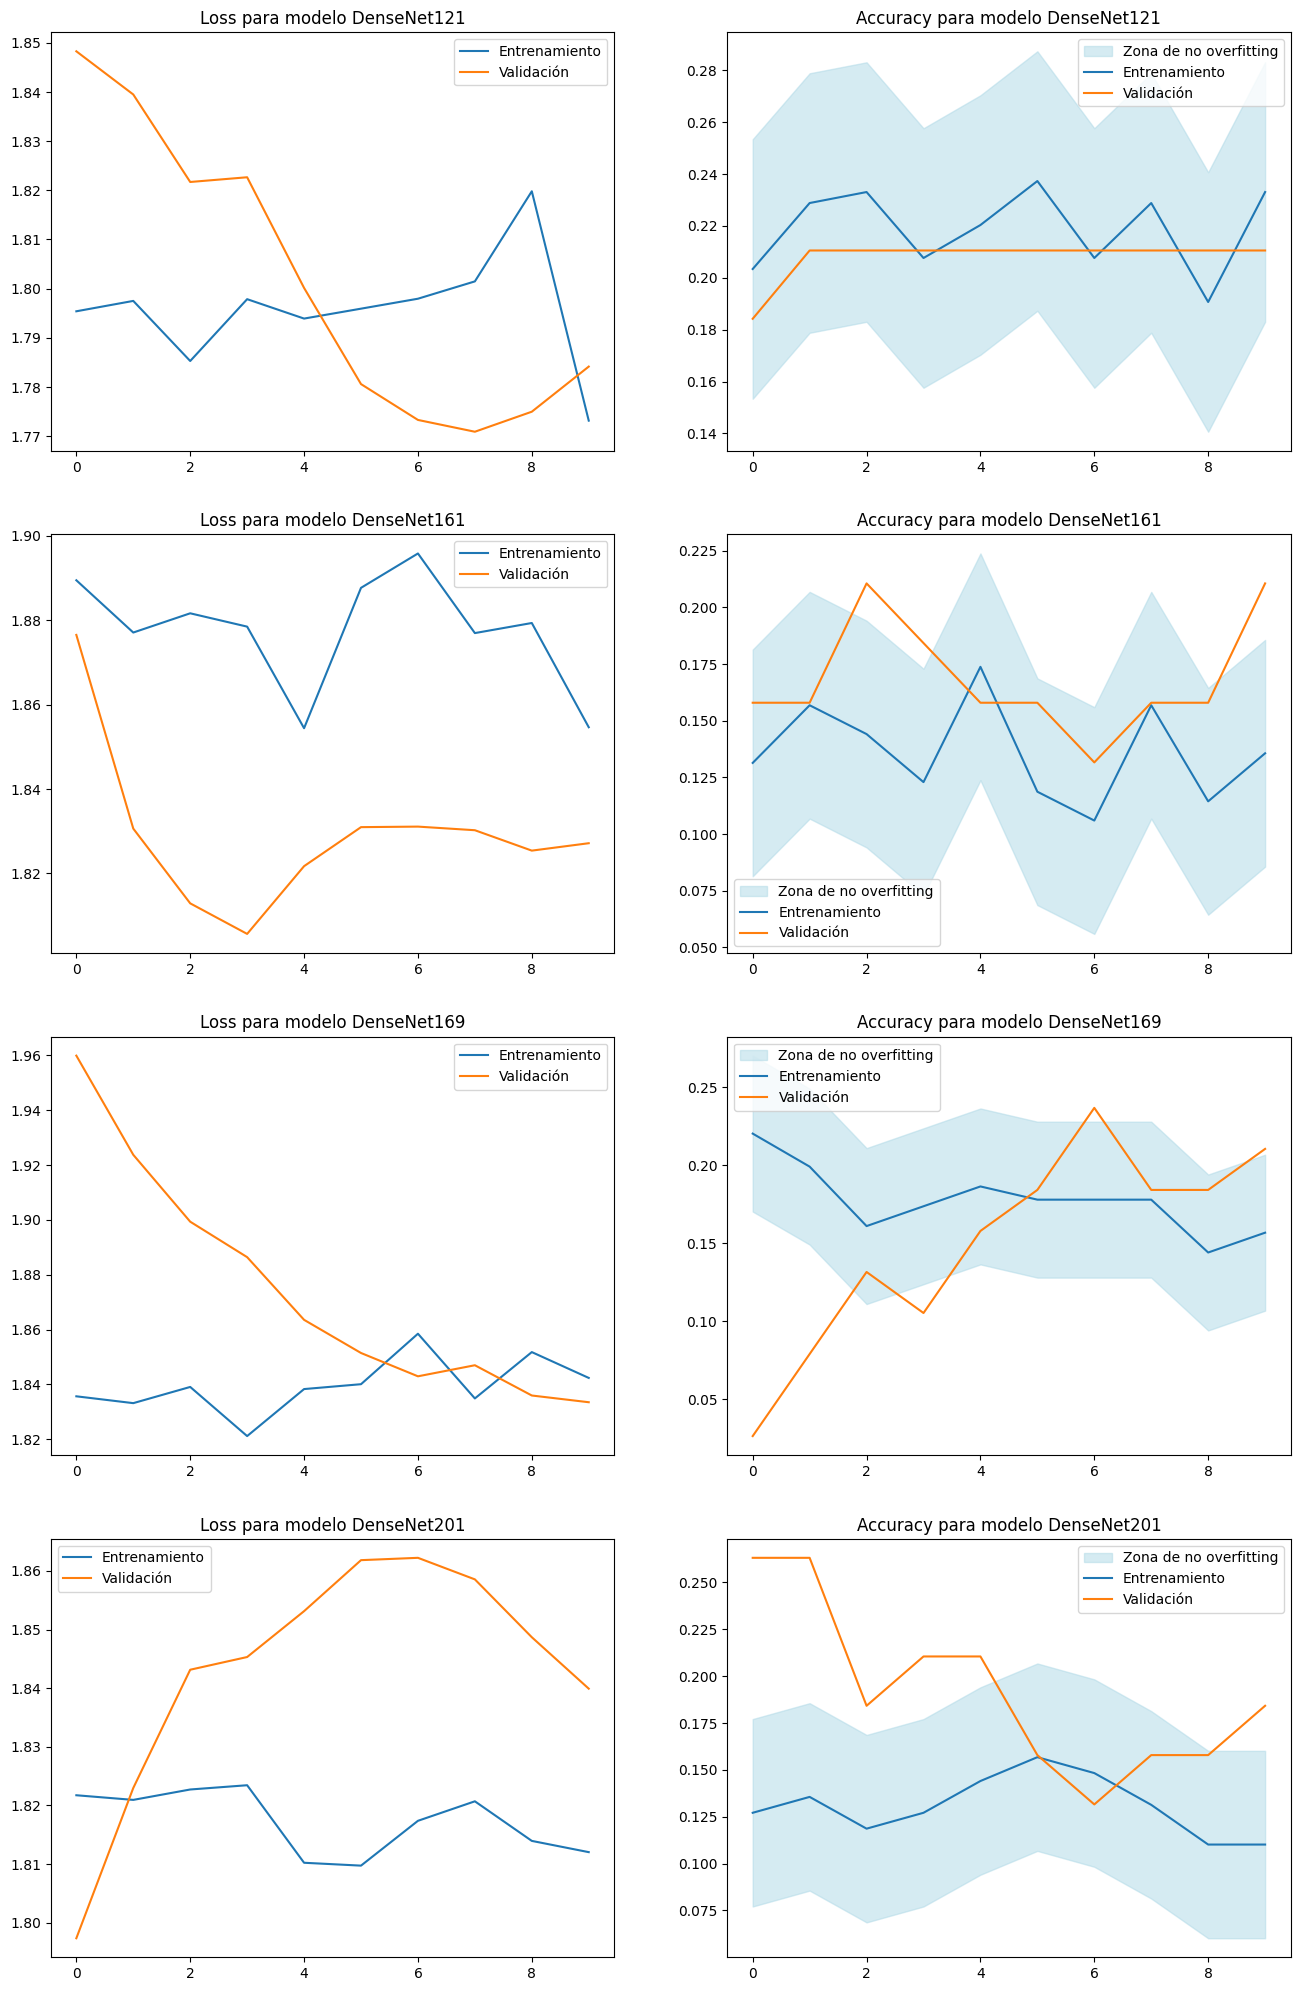

In [24]:
fig, axs = plt.subplots(nrows=len(num_model), ncols=2, figsize=(16,25))

loss = axs[:, 0]
acc = axs[:, 1]

for i, num in enumerate(num_model):
    loss[i].plot(train_loss_densenet[i], label='Entrenamiento')
    loss[i].plot(val_loss_densenet[i], label='Validación')

    train_acc_densenet[i] = [value.cpu().detach().numpy() for value in train_acc_densenet[i]]
    val_acc_densenet[i] = [value.cpu().detach().numpy() for value in val_acc_densenet[i]]

    lower_bound = [value - 0.05 for value in train_acc_densenet[i]]
    upper_bound = [value + 0.05 for value in train_acc_densenet[i]]

    acc[i].fill_between(list(range(num_epochs)), lower_bound, upper_bound, color='lightblue', alpha=0.5, label='Zona de no overfitting')

    acc[i].plot(train_acc_densenet[i], label='Entrenamiento')
    acc[i].plot(val_acc_densenet[i], label='Validación')

    loss[i].set_title(f"Loss para modelo DenseNet{num}")
    acc[i].set_title(f"Accuracy para modelo DenseNet{num}")

    loss[i].legend()
    acc[i].legend()

plt.show()

In [25]:
# Predecimos
for i, num in enumerate(num_model):
    model = models_densenet[i]
    model.eval()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model.to(device)

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total

    print(f'Test Accuracy para DenseNet{num}: {accuracy:.2f}%')

Test Accuracy para DenseNet121: 24.32%
Test Accuracy para DenseNet161: 10.81%
Test Accuracy para DenseNet169: 24.32%
Test Accuracy para DenseNet201: 22.97%


>Igual que en la parte de Finetuning, hemos analizado los modelos: ResNet, VGG y DenseNet, cambiando el número de capas. Cada modelo fue entrenado durante diez (10) épocas, y se guardaron los pesos en la épocas donde aumentaba el accuracy en el conjunto de validación y no existía overfitting.
>
>En este caso, vemos que todos los modelos tienen un accuracy bajo (menor a 25%) en el conjunto de prueba, siendo DenseNet121 y DenseNet169 los más altos (24.32% de accuracy). Esto se explica al entrenamiento que estamos realizando y el tipo de datos con los cuales estamos entrenando. 
>
>En Finetuning entrenábamos la red entera partiendo de los pesos obtenidos que resuelven el problema de clasificación en otro conjunto de datos, mientras que en Freezing utilizamos la red entera tal cual fue entrenada y solo entrenamos la última capa. Podemos ver esta diferencia en los resultados obtenidos. Con Finetuning intentamos adaptar la red al nuevo conjunto de datos, mientras que con Freezing intentamos usar la misma red, y el problema es que el nuevo conjunto de datos tiene una distribución completamente diferente al dataset con el cual fue entrenado el modelo, por lo que no es recomendable entrenar estos modelos usando Freezing para resolver este problema de clasificación sobre este conjunto de datos.